In [7]:
#Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import KFold
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys
import foolbox, time
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB *  of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
#Load CIFAR100 Dataset
#Quelle
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar100/load_data
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
x_train = (x_train / 255.0)- 0.5
x_test = (x_test / 255.0)- 0.5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [9]:
#Filter Images to get CIFAR10 without CIFAR90
truth_array = (y_train==0) | (y_train==1) | (y_train==2) | (y_train==3) | (y_train==4) | (y_train==5)| (y_train==6)| (y_train==7)| (y_train==8)| (y_train==9)
truth_array_test = (y_test==0) | (y_test==1) | (y_test==2) | (y_test==3) | (y_test==4) | (y_test==5)| (y_test==6)| (y_test==7)| (y_test==8)| (y_test==9)


truth_array = truth_array.flatten()
truth_array_test = truth_array_test.flatten()
#print(truth_array.shape)

x_train_new = x_train[truth_array]
dt = np.dtype(np.uint8)
y_train_new=np.array([], dtype=dt)


for value in y_train:
    if value < 10:
        y_train_new = np.append(y_train_new, value)

print(x_train_new.shape)
print(y_train_new.shape)

x_test_new = x_test[truth_array_test]
dt = np.dtype(np.uint8)
y_test_new=np.array([], dtype=dt)

for value in y_test:
    if value < 10:
        y_test_new = np.append(y_test_new, value)

y_train_new = y_train_new.reshape(y_train_new.shape[0], 1)
y_test_new = y_test_new.reshape(y_test_new.shape[0], 1)

#inputs and targets for kFold training set
inputs = x_train_new
targets = y_train_new

(5000, 32, 32, 3)
(5000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

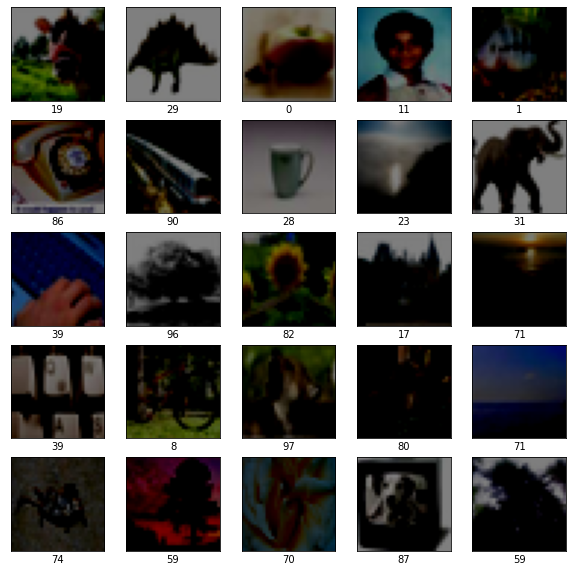

In [10]:
#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(y_train[i][0])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8]


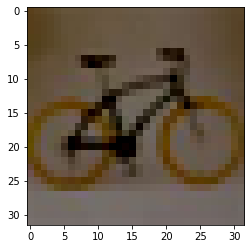

In [11]:
plt.imshow(x_train_new[100])
print(y_train_new[100])

In [12]:
#Quelle
#https://github.com/hiaghosh/Defensive-Distillation/blob/master/models/cifar10/cifar10.py
initial_learning_rate = 0.01

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * (drop_rate ** math.floor((1+epoch)/epochs_drop))

In [13]:
#Quelle
#https://scikit-learn.org/stable/modules/cross_validation.html#k-fold
num_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    #Create and Train the Model for CIFAR10
    #Quelle
    #Architektur CNN: https://arxiv.org/pdf/1608.04644.pdf
    #https://www.tensorflow.org/guide/keras/sequential_model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),  
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),   
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),  
      tf.keras.layers.Dense(256,activation='relu'),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.Dense(256,activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #model.summary()

    #Quelle
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

    checkpoint_filepath = f'tmp/checkpoint_red{fold_no}'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    #Quelle
    #https://www.tensorflow.org/guide/keras/train_and_evaluate

    history = model.fit(
        inputs[train], targets[train],
        epochs=50,
        batch_size=128,
        validation_data=(inputs[test], targets[test]),
        callbacks=[model_checkpoint_callback, LearningRateScheduler(lr_step_decay, verbose=1)],
    )
    
    #model.load_weights(checkpoint_filepath)
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(model.metrics_names)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Save the entire model
    !mkdir -p saved_models_cifar_red_kfold
    model.save(f'saved_models_cifar_red_kfold/base_model_cifar10_red_{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 3s 41ms/step - loss: 2.3011 - accuracy: 0.0986 - val_loss: 2.2973 - val_accuracy: 0.0960
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 22ms/step - loss: 2.2827 - accuracy: 0.1421 - val_loss: 2.2146 - val_accuracy: 0.2380
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 22ms/step - loss: 2.1553 - accuracy: 0.2451 - val_loss: 1.8754 - val_accuracy: 0.3440
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 22ms/step - loss: 1.8943 - accuracy: 0.3277 - val_loss: 1.7925 - val_accuracy: 0.3580
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning ra

36/36 [==============================] - 1s 22ms/step - loss: 0.6759 - accuracy: 0.7721 - val_loss: 1.1487 - val_accuracy: 0.6180
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 22ms/step - loss: 0.6700 - accuracy: 0.7660 - val_loss: 1.1407 - val_accuracy: 0.6380
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 22ms/step - loss: 0.6698 - accuracy: 0.7693 - val_loss: 1.1400 - val_accuracy: 0.6360
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 22ms/step - loss: 0.6460 - accuracy: 0.7858 - val_loss: 1.1379 - val_accuracy: 0.6560
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 22ms/step - loss: 0.6520 - accuracy: 0.7783 - val_loss: 1.1650 - val_accuracy: 0.6400
Epoch 44/50

E

36/36 [==============================] - 1s 22ms/step - loss: 0.9812 - accuracy: 0.6680 - val_loss: 1.1074 - val_accuracy: 0.6380
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 22ms/step - loss: 0.9339 - accuracy: 0.6836 - val_loss: 1.1214 - val_accuracy: 0.6320
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 22ms/step - loss: 0.9034 - accuracy: 0.6823 - val_loss: 1.2019 - val_accuracy: 0.6160
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 22ms/step - loss: 0.8904 - accuracy: 0.6944 - val_loss: 1.1589 - val_accuracy: 0.6300
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
36/36 [==============================] - 1s 22ms/step - loss: 0.8801 - accuracy: 0.6999 - val_loss: 1.0762 - val_accuracy: 0.6620
Epoch 31/50

Epoch 00

36/36 [==============================] - 1s 23ms/step - loss: 1.3256 - accuracy: 0.5349 - val_loss: 1.3668 - val_accuracy: 0.5280
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2884 - accuracy: 0.5584 - val_loss: 1.4144 - val_accuracy: 0.5060
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2563 - accuracy: 0.5690 - val_loss: 1.4265 - val_accuracy: 0.5080
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2298 - accuracy: 0.5777 - val_loss: 1.4068 - val_accuracy: 0.5120
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.1821 - accuracy: 0.6082 - val_loss: 1.2953 - val_accuracy: 0.5600
Epoch 18/50

Epoch 00018: 

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 26ms/step - loss: 2.3012 - accuracy: 0.1299 - val_loss: 2.2950 - val_accuracy: 0.1500
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.2847 - accuracy: 0.1794 - val_loss: 2.2403 - val_accuracy: 0.1940
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.1691 - accuracy: 0.2297 - val_loss: 1.9252 - val_accuracy: 0.3180
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 1.9388 - accuracy: 0.3138 - val_loss: 1.7489 - val_accuracy: 0.3740
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning ra

36/36 [==============================] - 1s 23ms/step - loss: 0.6871 - accuracy: 0.7616 - val_loss: 0.9792 - val_accuracy: 0.6840
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6832 - accuracy: 0.7605 - val_loss: 0.9728 - val_accuracy: 0.6940
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6381 - accuracy: 0.7880 - val_loss: 0.9681 - val_accuracy: 0.6800
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6651 - accuracy: 0.7741 - val_loss: 0.9917 - val_accuracy: 0.6860
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6318 - accuracy: 0.7786 - val_loss: 1.0014 - val_accuracy: 0.6740
Epoch 44/50

E

36/36 [==============================] - 1s 23ms/step - loss: 0.9486 - accuracy: 0.6623 - val_loss: 1.1099 - val_accuracy: 0.6640
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.8942 - accuracy: 0.6995 - val_loss: 1.0992 - val_accuracy: 0.6520
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.8778 - accuracy: 0.6913 - val_loss: 1.1215 - val_accuracy: 0.6520
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.8824 - accuracy: 0.6981 - val_loss: 1.1725 - val_accuracy: 0.6420
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
36/36 [==============================] - 1s 23ms/step - loss: 0.8525 - accuracy: 0.7083 - val_loss: 1.1228 - val_accuracy: 0.6520
Epoch 31/50

Epoch 00

36/36 [==============================] - 1s 23ms/step - loss: 1.3187 - accuracy: 0.5379 - val_loss: 1.3713 - val_accuracy: 0.5460
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2628 - accuracy: 0.5622 - val_loss: 1.3317 - val_accuracy: 0.5720
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2503 - accuracy: 0.5796 - val_loss: 1.3620 - val_accuracy: 0.5440
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2160 - accuracy: 0.5851 - val_loss: 1.3548 - val_accuracy: 0.5560
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2241 - accuracy: 0.5876 - val_loss: 1.3282 - val_accuracy: 0.5640
Epoch 18/50

Epoch 00018: 

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 26ms/step - loss: 2.3014 - accuracy: 0.1160 - val_loss: 2.2901 - val_accuracy: 0.1620
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.2812 - accuracy: 0.1846 - val_loss: 2.1976 - val_accuracy: 0.3000
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.1401 - accuracy: 0.2429 - val_loss: 1.9214 - val_accuracy: 0.3040
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 1.8859 - accuracy: 0.3203 - val_loss: 1.8051 - val_accuracy: 0.3440
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning ra

36/36 [==============================] - 1s 23ms/step - loss: 0.7140 - accuracy: 0.7480 - val_loss: 1.0463 - val_accuracy: 0.6700
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6981 - accuracy: 0.7571 - val_loss: 1.0511 - val_accuracy: 0.6640
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6422 - accuracy: 0.7883 - val_loss: 1.0522 - val_accuracy: 0.6620
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6847 - accuracy: 0.7578 - val_loss: 1.0413 - val_accuracy: 0.6660
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6673 - accuracy: 0.7702 - val_loss: 1.0428 - val_accuracy: 0.6640
Epoch 44/50

E

36/36 [==============================] - 1s 23ms/step - loss: 1.0015 - accuracy: 0.6583 - val_loss: 1.2242 - val_accuracy: 0.5880
Epoch 27/50

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.9631 - accuracy: 0.6680 - val_loss: 1.2221 - val_accuracy: 0.5980
Epoch 28/50

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.9606 - accuracy: 0.6726 - val_loss: 1.1958 - val_accuracy: 0.5900
Epoch 29/50

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0025.
36/36 [==============================] - 1s 23ms/step - loss: 0.8996 - accuracy: 0.6822 - val_loss: 1.1989 - val_accuracy: 0.5900
Epoch 30/50

Epoch 00030: LearningRateScheduler reducing learning rate to 0.00125.
36/36 [==============================] - 1s 23ms/step - loss: 0.9129 - accuracy: 0.6862 - val_loss: 1.1877 - val_accuracy: 0.6000
Epoch 31/50

Epoch 00

36/36 [==============================] - 1s 23ms/step - loss: 1.4846 - accuracy: 0.4938 - val_loss: 1.4158 - val_accuracy: 0.5100
Epoch 14/50

Epoch 00014: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.3746 - accuracy: 0.5199 - val_loss: 1.3633 - val_accuracy: 0.5440
Epoch 15/50

Epoch 00015: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.3454 - accuracy: 0.5307 - val_loss: 1.6189 - val_accuracy: 0.4800
Epoch 16/50

Epoch 00016: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.3399 - accuracy: 0.5414 - val_loss: 1.3288 - val_accuracy: 0.5500
Epoch 17/50

Epoch 00017: LearningRateScheduler reducing learning rate to 0.005.
36/36 [==============================] - 1s 23ms/step - loss: 1.2788 - accuracy: 0.5638 - val_loss: 1.3517 - val_accuracy: 0.5340
Epoch 18/50

Epoch 00018: 

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 26ms/step - loss: 2.3003 - accuracy: 0.1255 - val_loss: 2.2889 - val_accuracy: 0.2040
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.2727 - accuracy: 0.1817 - val_loss: 2.1663 - val_accuracy: 0.2100
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 2.0804 - accuracy: 0.2600 - val_loss: 1.9228 - val_accuracy: 0.2560
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
36/36 [==============================] - 1s 23ms/step - loss: 1.8961 - accuracy: 0.3346 - val_loss: 1.8456 - val_accuracy: 0.3560
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning r

36/36 [==============================] - 1s 23ms/step - loss: 0.7771 - accuracy: 0.7422 - val_loss: 1.1961 - val_accuracy: 0.6240
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.7205 - accuracy: 0.7549 - val_loss: 1.1603 - val_accuracy: 0.6460
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.7250 - accuracy: 0.7580 - val_loss: 1.1659 - val_accuracy: 0.6320
Epoch 42/50

Epoch 00042: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.7054 - accuracy: 0.7538 - val_loss: 1.1684 - val_accuracy: 0.6280
Epoch 43/50

Epoch 00043: LearningRateScheduler reducing learning rate to 0.000625.
36/36 [==============================] - 1s 23ms/step - loss: 0.6786 - accuracy: 0.7757 - val_loss: 1.1796 - val_accuracy: 0.6280
Epoch 44/50

E

In [ ]:
#Quelle
#https://www.tensorflow.org/tutorials/images/transfer_learning

def display_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(title)
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# Display training curve 
display_history(history, "CNN Model CIFAR10 Reduced")

In [ ]:
#Predict random image
y=model.predict(x_test_new)
print(np.argmax(y[1500]))
plt.imshow(x_test_new[1500], cmap=plt.cm.binary)

In [24]:
import pandas as pd
# Evaluate all 10 models
accuracy = list()
for i in range(1,11):
    model = tf.keras.models.load_model(f'saved_models_cifar_red_kfold/base_model_cifar10_red_{i}')
    model.load_weights(f'tmp/checkpoint_red{i}')

    loss, acc = model.evaluate(x_test_new, y_test_new, verbose=2)
    print('Accuracy: {:5.2f}%'.format(100 * acc))
    accuracy.append(acc)
    print(model.predict(x_test_new).shape)
    
    df = pd.DataFrame(accuracy, columns=['Scores'])
    df.to_excel('accuracy.xlsx', sheet_name='kfold', index=False)

32/32 - 0s - loss: 1.0620 - accuracy: 0.6610
Accuracy: 66.10%
(1000, 10)
32/32 - 0s - loss: 1.1574 - accuracy: 0.6420
Accuracy: 64.20%
(1000, 10)
32/32 - 0s - loss: 1.0873 - accuracy: 0.6570
Accuracy: 65.70%
(1000, 10)
32/32 - 0s - loss: 0.9910 - accuracy: 0.6860
Accuracy: 68.60%
(1000, 10)
32/32 - 0s - loss: 1.0848 - accuracy: 0.6550
Accuracy: 65.50%
(1000, 10)
32/32 - 0s - loss: 1.0809 - accuracy: 0.6650
Accuracy: 66.50%
(1000, 10)
32/32 - 0s - loss: 1.0991 - accuracy: 0.6550
Accuracy: 65.50%
(1000, 10)
32/32 - 0s - loss: 1.1174 - accuracy: 0.6390
Accuracy: 63.90%
(1000, 10)
32/32 - 0s - loss: 1.1128 - accuracy: 0.6530


Accuracy: 65.30%
(1000, 10)
32/32 - 0s - loss: 1.1052 - accuracy: 0.6470
Accuracy: 64.70%
(1000, 10)


In [15]:
#Import Foolbox Packages
#Quelle
#https://foolbox.readthedocs.io/en/stable/
from foolbox import TensorFlowModel, accuracy, samples, Model, utils, attacks, plot
from foolbox.attacks import LinfPGD, LinfDeepFoolAttack
import pandas as pd

In [59]:
model = tf.keras.models.load_model(f'saved_models_cifar_red_kfold/base_model_cifar10_red_10')
model.load_weights(f'tmp/checkpoint_red10')

In [60]:
#Run an attack with foolbox
#Quelle
#https://github.com/bethgelab/foolbox
preprocessing = dict()
bounds = (-0.5, 0.5)
fmodel = TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((-0.5, 0.5))

attack_labels = tf.convert_to_tensor(y_test_new, dtype='int64')
attack_labels = tf.reshape(attack_labels, 1000)
attack_images = tf.convert_to_tensor(x_test_new, dtype='float32')

In [61]:
#Quelle
#https://www.kaggle.com/josephvm/generating-adversarial-examples-with-foolbox
predictions = model.predict(attack_images)
orig_predictions = np.argmax(predictions, axis = 1)
print(f"Accuracy:  {np.mean(orig_predictions == attack_labels) * 100:.2f} %") # Accuracy of original images
already_correct = np.sum(orig_predictions != attack_labels) # keep track of how many were already correct

Accuracy:  64.70 %


In [62]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
#PGD40 mit 20 Restarts, Table1
import eagerpy as ep
attack_images = ep.astensor(attack_images)
attack_labels = ep.astensor(attack_labels)
attack = attacks.LinfPGD()
epsilons = [
        0.0,
        0.0002,
        0.0005,
        0.0008,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.01,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        1.0,
    ]

success_rate = np.zeros(len(epsilons))

loop_array = np.array_split(np.arange(attack_images.shape[0]), 10)

for i , idx in enumerate(loop_array): 
    restarts = 20

    truth_array = np.zeros(shape=(len(epsilons),len(idx)), dtype=bool)
    print('Batch: ', i)
    for k in range(restarts):
        print('Restart: ', k)
        raw, clipped, is_adv = attack(fmodel, attack_images[idx], attack_labels[idx], epsilons=epsilons)
        arr = is_adv.numpy()
        truth_array = truth_array | arr
    
    success_rate += np.sum(truth_array, axis=1)
#print(attack_images.shape)
#print('Success Rate:', success_rate / attack_images.shape[0])
    
print("Attack finished!")
print('Success Rate:', success_rate / attack_images.shape[0])
df = pd.DataFrame((success_rate / attack_images.shape[0]), columns=['Success_rate'])
df.to_excel('attack_success_rate.xlsx', sheet_name='attack', index=False)

Batch:  0
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  1
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  2
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16
Restart:  17
Restart:  18
Restart:  19
Batch:  3
Restart:  0
Restart:  1
Restart:  2
Restart:  3
Restart:  4
Restart:  5
Restart:  6
Restart:  7
Restart:  8
Restart:  9
Restart:  10
Restart:  11
Restart:  12
Restart:  13
Restart:  14
Restart:  15
Restart:  16

In [ ]:
#Quelle
#https://foolbox.jonasrauber.de/guide/examples.html
accuracy = list()
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.2f} %")
    accuracy.append(acc.item() * 100)
print("---------------------------------------------------------")

#Quelle
#https://matplotlib.org/stable/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py
#https://github.com/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb
plt.plot(epsilons, robust_accuracy.numpy() * 100)
#plt.plot(epsilon, label='Epsilon')
#plt.legend(loc='upper right')
plt.ylabel('Accuracy in (%)')
plt.title('Robust Accuracy')
plt.xlabel('Epsilon')
plt.show()

#Quelle
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('robust_accuracy.png', dpi=300, bbox_inches='tight')

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
df = pd.DataFrame(accuracy)

#Quelle
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html
df.to_excel('robust_accuracy_cifar10RED.xlsx', sheet_name='attack', index=False)

In [ ]:
acc = np.zeros(shape=(len(epsilons)))
#for loop über alle epsilons
for i in range(len(epsilons)):
    print("Epsilon:      ", epsilons[i])
    predictions = model.predict(raw[i])
    adv_predictions = np.argmax(predictions, axis = 1)
    print("Accuracy: ", np.mean(adv_predictions == attack_labels)) # Accuracy of adversarial images
    print("--------------------------------------------------------------")
    print("")
    print("--------------------------------------------------------------")
    acc[i] = np.mean(adv_predictions == attack_labels)
plt.plot(epsilons, acc)

In [ ]:
print('Versionsinformationen der Module:')
print(sys.executable)
print(sys.version)
print(sys.version_info)
!conda --version
!python --version
print('Tensorflow: ' + tf.__version__)
print('Tensorflow Datasets: ' + tfds.__version__)
print('Scikit Learn: ' + sklearn.__version__)
print('Eagerpy: ' + ep.__version__)
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__)
print('Foolbox: ' + foolbox.__version__)
print('Pandas: ' + pd.__version__)